In [3]:
import numpy as np
import os
import random
import csv
import collections
import math
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Bidirectional, LSTM
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('./traindga5.csv')

In [5]:
df = df.dropna()

In [6]:
df.head()

,legit,alexa,youtube,-0.8,0.0615473378,1,-0.8062361783,-0.7826991542,-0.760304862,-0.7321765588,-0.8396402652,-1
0,legit,alexa,vk,-0.966667,-0.579025,-1.0,-1.000000,-0.962000,-0.972786,-1.000000,-1.000000,-1.000000
1,legit,alexa,aliexpress,-0.700000,0.230058,1.0,-0.609187,-0.670833,-0.622968,-0.608980,-0.666030,-0.636043
2,legit,alexa,pornhub,-0.800000,0.181826,1.0,-0.878869,-0.782895,-0.763826,-0.830235,-0.903668,-1.000000
3,legit,alexa,livejasmin,-0.700000,0.314253,1.0,-0.787137,-0.676048,-0.636485,-0.653389,-0.911703,-1.000000
4,legit,alexa,popads,-0.833333,-0.052121,1.0,-0.897885,-0.814695,-0.794943,-0.808468,-1.000000,-1.000000


In [7]:
# Lấy binary labels
binary_labels = [row[0] for idx, row in df.iterrows()]
binary_labels[:10]

['legit',
 'legit',
 'legit',
 'legit',
 'legit',
 'legit',
 'legit',
 'legit',
 'legit',
 'legit']

In [8]:
# Lấy danh sách domain
X = [row[2] for idx, row in df.iterrows()]
X[:10]

['vk',
 'aliexpress',
 'pornhub',
 'livejasmin',
 'popads',
 'microsoftonline',
 'wikia',
 'bongacams',
 'xvideos',
 'detik']

In [9]:
# Lấy danh sách labels (multi-class)
labels = [row[1] for idx, row in df.iterrows()]
labels[:10]

['alexa',
 'alexa',
 'alexa',
 'alexa',
 'alexa',
 'alexa',
 'alexa',
 'alexa',
 'alexa',
 'alexa']

In [10]:
# Tạo dictionary, ánh xạ mỗi kí tự sang 1 số nguyên
valid_chars = {x: idx + 1 for idx, x in enumerate(set(''.join(X)))}

max_features = len(valid_chars) + 1
maxlen = np.max([len(x) for x in X])

In [11]:
# Ánh xạ và padding
X = [[valid_chars[y] for y in x] for x in X]
X = sequence.pad_sequences(X, maxlen=maxlen)

In [12]:
# Encode label
y_binary = np.array([0 if x == 'legit' else 1 for x in binary_labels])
valid_class = {i:indx for indx, i in enumerate(set(labels))}
y = [valid_class[x] for x in labels]
y = np.array(y)

print(y_binary[:10])
print('--------------')
print(y[:10])

[0 0 0 0 0 0 0 0 0 0]
--------------
[19 19 19 19 19 19 19 19 19 19]


In [13]:
def build_binary_model(max_features, maxlen):
    """Build LSTM model for two-class classification using Bi-LSTM"""
    model = Sequential()
    model.add(Embedding(max_features, 128, input_length=maxlen))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='rmsprop')

    return model

def build_multiclass_model(max_features, maxlen):
    """Build multiclass LSTM model for multiclass classification using Bi-LSTM"""
    model = Sequential()
    model.add(Embedding(max_features, 128, input_length=maxlen))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dropout(0.5))
    model.add(Dense(38))  # Có 38 loại
    model.add(Activation('softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

    return model

In [14]:
def create_class_weight(labels_dict, mu):
    """Create weight based on the number of domain name in the dataset"""
    total = np.sum(list(labels_dict.values()))
    class_weight = dict()

    for key in labels_dict.keys():
        # Calculate the class weight using the provided formula
        score = math.pow(total / float(labels_dict[key]), mu)
        class_weight[key] = score

    return class_weight

In [15]:
# Chia tập dữ liệu cho bài toán phân loại nhị phân
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X, y_binary, test_size=0.3, random_state=42, stratify=y_binary)

# Chia tập dữ liệu cho bài toán phân loại đa lớp
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [16]:
print(X_train_bin.shape)
print(y_train_bin.shape)
print(X_test_bin.shape)
print(y_test_bin.shape)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(118891, 61)
(118891,)
(50954, 61)
(50954,)
(118891, 61)
(118891,)
(50954, 61)
(50954,)


In [17]:
# Tạo model
binary_model = build_binary_model(max_features, maxlen)
model = build_multiclass_model(max_features, maxlen)

In [18]:
EPOCHS = 20

In [19]:
def evaluate_model(y_true, y_pred, y_pred_proba, model_type='binary'):
    # Tính các chỉ số đánh giá
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='binary' if model_type == 'binary' else 'weighted')
    rec = recall_score(y_true, y_pred, average='binary' if model_type == 'binary' else 'weighted')
    f1 = f1_score(y_true, y_pred, average='binary' if model_type == 'binary' else 'weighted')

    # In các chỉ số
    print(f"Accuracy: {acc}")
    print(f"Precision: {prec}")
    print(f"Recall: {rec}")
    print(f"F1 Score: {f1}")

    # Vẽ đường cong ROC và tính AUC
    if model_type == 'binary':
        fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
        roc_auc = auc(fpr, tpr)
    elif model_type == 'multiclass':
        # Tính AUC cho phân loại đa lớp
        roc_auc = roc_auc_score(y_true, y_pred_proba, multi_class='ovr')

    plt.figure()
    if model_type == 'binary':
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    elif model_type == 'multiclass':
        # Không vẽ đường cong ROC cho phân loại đa lớp ở đây
        plt.title('Multiclass classification - ROC AUC provided')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return acc, prec, rec, f1, roc_auc

In [20]:
# BINARY-CLASS

# Train
labels_dict=collections.Counter(y_train_bin)
class_weight = create_class_weight(labels_dict, 0.1)
binary_model.fit(X_train_bin, y_train_bin, batch_size=128, epochs=1, class_weight=class_weight)

y_pred_bin_probs = binary_model.predict(X_test_bin)
print(y_pred_bin_probs[:5])

1593/1593 [==============================] - 68s 42ms/step
[[0.04315161]
 [0.00602583]
 [0.92109114]
 [0.6130993 ]
 [0.9968809 ]]


In [21]:

y_pred_bin = [0 if(x<=0.5) else 1 for x in y_pred_bin_probs]

Accuracy: 0.9479138046080778
Precision: 0.9462004585653455
Recall: 0.9451942740286299
F1 Score: 0.9456970986618652


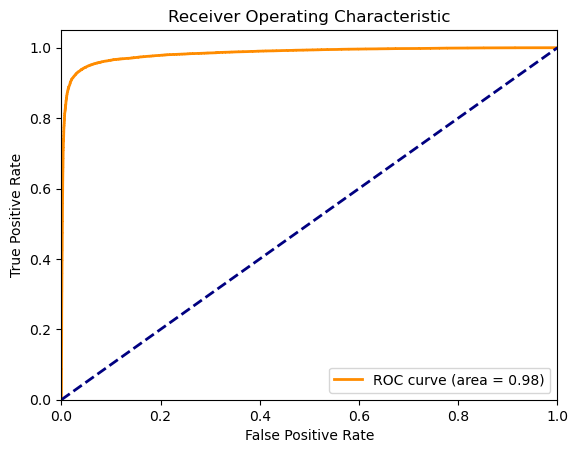

(0.9479138046080778,
 0.9462004585653455,
 0.9451942740286299,
 0.9456970986618652,
 0.9837644802003881)

In [22]:
# Đánh giá
evaluate_model(y_test_bin, y_pred_bin, y_pred_bin_probs, model_type='binary')

In [23]:
# MULTI-CLASS

# Train
labels_dict=collections.Counter(y_train)
class_weight = create_class_weight(labels_dict, 0.1)
model.fit(X_train, y_train, batch_size=128, epochs=1, class_weight=class_weight)

y_pred_proba= model.predict(X_test)
y_pred = [np.argmax(x) for x in y_pred_proba]

1593/1593 [==============================] - 106s 65ms/step


/home/haohao/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.8782431212466146
Precision: 0.841207639811053
Recall: 0.8782431212466146
F1 Score: 0.8509734746604322


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


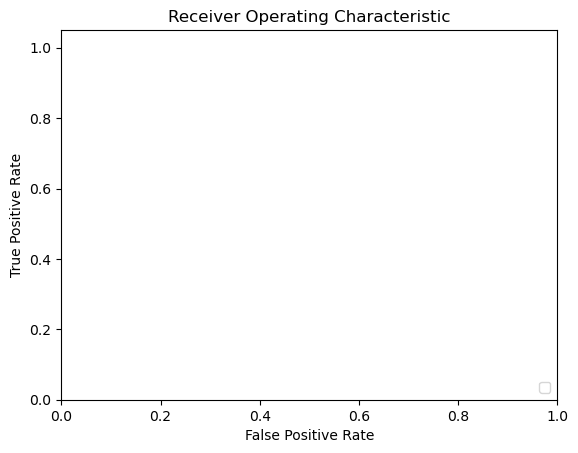

(0.8782431212466146,
 0.841207639811053,
 0.8782431212466146,
 0.8509734746604322,
 0.8987038053364834)

In [24]:
# Đánh giá
evaluate_model(y_test, y_pred, y_pred_proba, model_type='multiclass')